## MSE variables

mse:

$h = c_{p}T + gz + L_{v}q$

<br />
development of spatial variance of mass weighted vertically integrated mse:

$\frac{1}{2} \hat{\frac{\delta {h ^ \prime} ^2}{\delta t}} = \text{forcing correlation terms}$

$h ^ \prime$ - moist static energy anomaly from the domain mean \
$\delta t$ - one day


&#8291;1.  ta    –  temperature air \
2. gz    –  geopotential height \
3. hus   -  humidity specific

<br />

In [2]:
import intake
import xarray as xr
#import xesmf as xe

import numpy as np
import skimage.measure as skm
import scipy

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat

import os
import myFuncs
import myPlots

In [2]:
model='MPI-ESM1-2-HR'
experiment_id='historical'
period = slice('1970-01-01','1999-12-31')
member_id='r1i1p1f1'


## ta   -  temperature air

In [4]:
table_id='day'
variable_id = 'ta'
ds_dict= intake.cat.nci['esgf'].cmip6.search(
                                source_id=model, 
                                experiment_id=experiment_id, 
                                member_id=member_id, 
                                variable_id=variable_id, 
                                table_id=table_id).to_dataset_dict()
ds = ds_dict[list(ds_dict.keys())[-1]].sel(time=period, lon=slice(0,360),lat=slice(-30,30))

In [7]:
ds

<xarray.Dataset>
Dimensions:    (time: 60265, bnds: 2, plev: 8, lat: 192, lon: 384)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-01T12:00:00 ... 2014-12-31T12:00:00
  * plev       (plev) float64 1e+05 8.5e+04 7e+04 5e+04 ... 1e+04 5e+03 1e+03
  * lat        (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * lon        (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(1826, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 -89.75 -88.82 -88.82 ... 88.82 88.82 89.75
    lon_bnds   (lon, bnds) float64 -0.4688 0.4688 0.4688 ... 358.6 358.6 359.5
    ta         (time, plev, lat, lon) float32 dask.array<chunksize=(1826, 8, 192, 384), meta=np.ndarray>
Attributes: (12/49)
    experiment:              all-forcing simulation of the recent past
    history:                 2019-08-25T06:42:13Z ; CMOR rewrote data to be c...
    frequency:               day
    parent_experiment_id:    piControl
    activity_id:             CMIP
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.MPI-M.MPI-E...
    ...                      ...
    branch_time_in_child:    0.0
    intake_esm_varname:      ['ta']
    variable_id:             ta
    data_specs_version:      01.00.30
    product:                 model-output
    intake_esm_dataset_key:  CMIP6.CMIP.MPI-M.MPI-ESM1-2-HR.historical.r1i1p1...

In [1]:
ta=ds.ta #-273.15
#ta.attrs['units']= 'C\xb0'
ta

NameError: name 'ds' is not defined

In [9]:
ta_test=ta.isel(time=slice(0, 4)) 
ta_test

<xarray.DataArray 'ta' (time: 4, plev: 8, lat: 64, lon: 384)>
dask.array<sub, shape=(4, 8, 64, 384), dtype=float32, chunksize=(4, 8, 64, 384), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1970-01-01T12:00:00 ... 1970-01-04T12:00:00
  * plev     (plev) float64 1e+05 8.5e+04 7e+04 5e+04 2.5e+04 1e+04 5e+03 1e+03
  * lat      (lat) float64 -29.45 -28.52 -27.58 -26.65 ... 27.58 28.52 29.45
  * lon      (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
Attributes:
    units:    C°

In [ ]:
#da = ta.isel(time=0).interpolate_na(dim="plev", method='polynomial', order=2, use_coordinate="plev", keep_attrs=True)
# ta_dayVint = xr.DataArray(
#     data=-scipy.integrate.simpson(ta, ta.plev.data, axis=1, even='last')/ta.plev.data[0],
#     dims=['time','lat', 'lon'],
#     coords={'time': ta.time.data, 'lat': ta.lat.data, 'lon': ta.lon.data},
#     attrs={'units':'mm/day'}
#     )

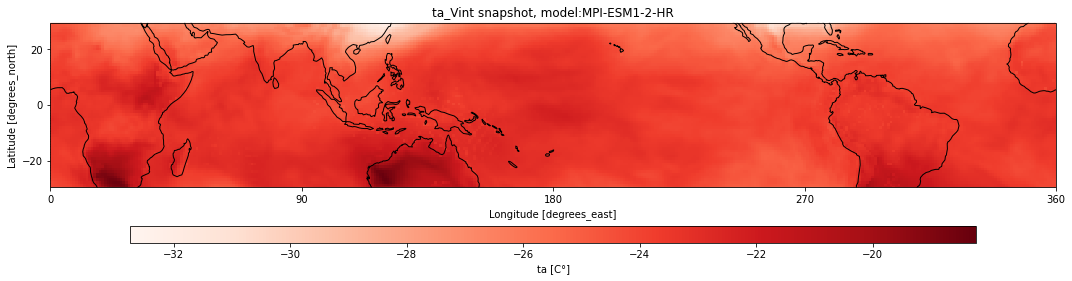

In [10]:
# myPlots.plot_snapshot(ta_dayVint, 'Reds', 'ta_Vint', model)

## zg    –  geopotential height

In [12]:
table_id='day'
variable_id = 'zg'
ds_dict= intake.cat.nci['esgf'].cmip6.search(
                                source_id=model, 
                                experiment_id=experiment_id, 
                                member_id=member_id, 
                                variable_id=variable_id, 
                                table_id=table_id).to_dataset_dict()

ds = ds_dict[list(ds_dict.keys())[-1]].sel(time=period, lon=slice(0,360),lat=slice(-30,30))

#print(sorted(list(subset.unique()['table_id'].values())[1]))
#len(list(subset.unique()['table_id'].values())[1])

In [16]:
ds

<xarray.Dataset>
Dimensions:    (time: 60265, bnds: 2, plev: 8, lat: 192, lon: 384)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-01T12:00:00 ... 2014-12-31T12:00:00
  * plev       (plev) float64 1e+05 8.5e+04 7e+04 5e+04 ... 1e+04 5e+03 1e+03
  * lat        (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * lon        (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(1826, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 -89.75 -88.82 -88.82 ... 88.82 88.82 89.75
    lon_bnds   (lon, bnds) float64 -0.4688 0.4688 0.4688 ... 358.6 358.6 359.5
    zg         (time, plev, lat, lon) float32 dask.array<chunksize=(1826, 8, 192, 384), meta=np.ndarray>
Attributes: (12/49)
    experiment:              all-forcing simulation of the recent past
    history:                 2019-08-25T06:42:13Z ; CMOR rewrote data to be c...
    frequency:               day
    parent_experiment_id:    piControl
    activity_id:             CMIP
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.MPI-M.MPI-E...
    ...                      ...
    branch_time_in_child:    0.0
    intake_esm_varname:      ['zg']
    variable_id:             zg
    data_specs_version:      01.00.30
    product:                 model-output
    intake_esm_dataset_key:  CMIP6.CMIP.MPI-M.MPI-ESM1-2-HR.historical.r1i1p1...

In [17]:
zg=ds.zg
zg

<xarray.DataArray 'zg' (time: 10957, plev: 8, lat: 64, lon: 384)>
dask.array<getitem, shape=(10957, 8, 64, 384), dtype=float32, chunksize=(1827, 8, 64, 384), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1970-01-01T12:00:00 ... 1999-12-31T12:00:00
  * plev     (plev) float64 1e+05 8.5e+04 7e+04 5e+04 2.5e+04 1e+04 5e+03 1e+03
  * lat      (lat) float64 -29.45 -28.52 -27.58 -26.65 ... 27.58 28.52 29.45
  * lon      (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
Attributes:
    standard_name:  geopotential_height
    long_name:      Geopotential Height
    comment:        Geopotential is the sum of the specific gravitational pot...
    units:          m
    cell_methods:   time: mean
    cell_measures:  area: areacella
    history:        2019-08-25T06:42:13Z altered by CMOR: Reordered dimension...

In [18]:
zg_test=zg.isel(time=slice(0, 4))
zg_test

<xarray.DataArray 'zg' (time: 4, plev: 8, lat: 64, lon: 384)>
dask.array<getitem, shape=(4, 8, 64, 384), dtype=float32, chunksize=(4, 8, 64, 384), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1970-01-01T12:00:00 ... 1970-01-04T12:00:00
  * plev     (plev) float64 1e+05 8.5e+04 7e+04 5e+04 2.5e+04 1e+04 5e+03 1e+03
  * lat      (lat) float64 -29.45 -28.52 -27.58 -26.65 ... 27.58 28.52 29.45
  * lon      (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
Attributes:
    standard_name:  geopotential_height
    long_name:      Geopotential Height
    comment:        Geopotential is the sum of the specific gravitational pot...
    units:          m
    cell_methods:   time: mean
    cell_measures:  area: areacella
    history:        2019-08-25T06:42:13Z altered by CMOR: Reordered dimension...

In [ ]:
# da = zg.isel(time=0).interpolate_na(dim="plev", method='polynomial', order=2, use_coordinate="plev", keep_attrs=True)
# zg_dayVint = xr.DataArray(
#     data=-scipy.integrate.simpson(da, zg.plev.data, axis=1, even='last')/zg.plev.data[0],
#     dims=['time','lat', 'lon'],
#     coords={'time': zg.time.data, 'lat': zg.lat.data, 'lon': zg.lon.data},
#     attrs={'units':'mm/day'}
#     )

# zg_dayVint=zg.isel(time=0).mean(dim='plev', keep_attrs=True) #.sel(plev=850e2)

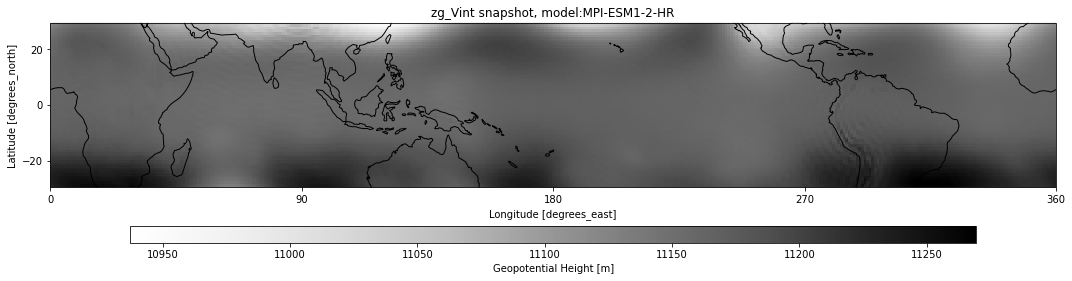

In [20]:
# myPlots.plot_snapshot(zg_dayVint, 'Greys', 'zg_Vint', model)

## hus   -  humidity specific

In [22]:
table_id='day'
variable_id = 'hus'
ds_dict= intake.cat.nci['esgf'].cmip6.search(
                                source_id=model, 
                                experiment_id=experiment_id, 
                                member_id=member_id, 
                                variable_id=variable_id, 
                                table_id=table_id).to_dataset_dict() 
                                
ds = ds_dict[list(ds_dict.keys())[-1]].sel(time=period, lon=slice(0,360),lat=slice(-30,30))

In [25]:
ds

<xarray.Dataset>
Dimensions:    (time: 60265, bnds: 2, plev: 8, lat: 192, lon: 384)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-01T12:00:00 ... 2014-12-31T12:00:00
  * plev       (plev) float64 1e+05 8.5e+04 7e+04 5e+04 ... 1e+04 5e+03 1e+03
  * lat        (lat) float64 -89.28 -88.36 -87.42 -86.49 ... 87.42 88.36 89.28
  * lon        (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] dask.array<chunksize=(1826, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 -89.75 -88.82 -88.82 ... 88.82 88.82 89.75
    lon_bnds   (lon, bnds) float64 -0.4688 0.4688 0.4688 ... 358.6 358.6 359.5
    hus        (time, plev, lat, lon) float32 dask.array<chunksize=(1826, 8, 192, 384), meta=np.ndarray>
Attributes: (12/49)
    experiment:              all-forcing simulation of the recent past
    history:                 2019-08-25T06:42:13Z ; CMOR rewrote data to be c...
    frequency:               day
    parent_experiment_id:    piControl
    activity_id:             CMIP
    further_info_url:        https://furtherinfo.es-doc.org/CMIP6.MPI-M.MPI-E...
    ...                      ...
    branch_time_in_child:    0.0
    intake_esm_varname:      ['hus']
    variable_id:             hus
    data_specs_version:      01.00.30
    product:                 model-output
    intake_esm_dataset_key:  CMIP6.CMIP.MPI-M.MPI-ESM1-2-HR.historical.r1i1p1...

In [26]:
hus=ds.hus #*1000
#hus.attrs['units']= 'g/kg'
hus

<xarray.DataArray 'hus' (time: 10957, plev: 8, lat: 64, lon: 384)>
dask.array<getitem, shape=(10957, 8, 64, 384), dtype=float32, chunksize=(1827, 8, 64, 384), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1970-01-01T12:00:00 ... 1999-12-31T12:00:00
  * plev     (plev) float64 1e+05 8.5e+04 7e+04 5e+04 2.5e+04 1e+04 5e+03 1e+03
  * lat      (lat) float64 -29.45 -28.52 -27.58 -26.65 ... 27.58 28.52 29.45
  * lon      (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
Attributes:
    standard_name:  specific_humidity
    long_name:      Specific Humidity
    comment:        Specific humidity is the mass fraction of water vapor in ...
    units:          1
    cell_methods:   time: mean
    cell_measures:  area: areacella
    history:        2019-08-25T06:42:13Z altered by CMOR: Reordered dimension...

In [27]:
hus_test=hus.isel(time=slice(0, 4))
hus_test

<xarray.DataArray 'hus' (time: 4, plev: 8, lat: 64, lon: 384)>
dask.array<mul, shape=(4, 8, 64, 384), dtype=float32, chunksize=(4, 8, 64, 384), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1970-01-01T12:00:00 ... 1970-01-04T12:00:00
  * plev     (plev) float64 1e+05 8.5e+04 7e+04 5e+04 2.5e+04 1e+04 5e+03 1e+03
  * lat      (lat) float64 -29.45 -28.52 -27.58 -26.65 ... 27.58 28.52 29.45
  * lon      (lon) float64 0.0 0.9375 1.875 2.812 ... 356.2 357.2 358.1 359.1
Attributes:
    units:    g/kg

In [ ]:
# da = hus.fillna(0)
# hus_dayVint = xr.DataArray(
#     data=-scipy.integrate.simpson(da, hus.plev.data, axis=1, even='last')/hus.plev.data[0],
#     dims=['time','lat', 'lon'],
#     coords={'time': hus.time.data, 'lat': hus.lat.data, 'lon': hus.lon.data}
#     ,attrs={'units':'mm/day'}
#     )

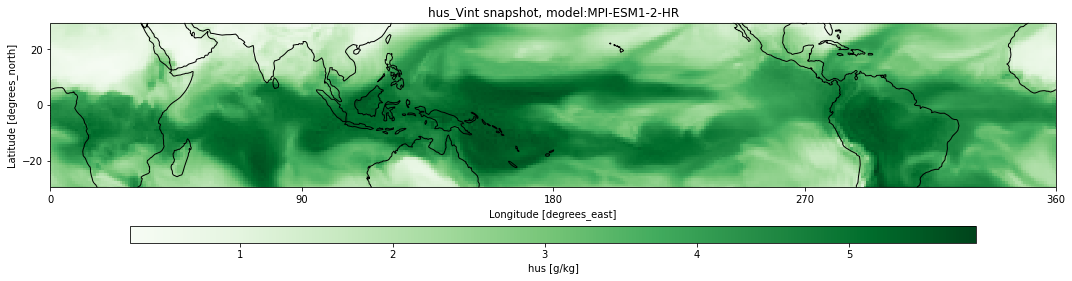

In [28]:
# myPlots.plot_snapshot(hus_dayVint, 'Greens', 'hus_Vint', model)

## mse

$h = c_{p}T + gz + L_{v}q$

In [3]:
model='MPI-ESM1-2-HR'
experiment_id='historical'
folder = '/Users/cbla0002/Documents/data/cmip6/' + model
fileName = model + '_mse_' + experiment_id + '.nc'
path = folder + '/' + fileName
ds = xr.open_dataset(path)

In [4]:
ds

<xarray.Dataset>
Dimensions:  (time: 10957, plev: 8, lat: 64, lon: 384)
Coordinates:
  * time     (time) datetime64[ns] 1970-01-01T12:00:00 ... 1999-12-31T12:00:00
  * plev     (plev) float64 1e+05 8.5e+04 7e+04 5e+04 2.5e+04 1e+04 5e+03 1e+03
  * lat      (lat) float64 -29.45 -28.52 -27.58 -26.65 ... 27.58 28.52 29.45
  * lon      (lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
Data variables:
    *empty*

In [ ]:
c_p = 1.005
L_v = 2.256e6
mse = c_p*ta + zg + L_v*hus

In [ ]:
del ta, zg, hus

In [ ]:
mse_test = mse.isel(time=slice(0,4))

In [ ]:
mse_vInt = xr.DataArray(
    data=-scipy.integrate.simpson(mse.data, mse.plev.data, axis=1, even='last')/mse.plev.data[0],
    dims=['time','lat', 'lon'],
    coords={'time': mse.time.data, 'lat': mse.lat.data, 'lon': mse.lon.data}
    ,attrs={'units':''}
    )

In [ ]:
myPlots.plot_snapshot(mse_vInt.mean(dim=('time'), keep_attrs=True), 'viridis', 'time mean mse vInt', model)

In [ ]:
aWeights = np.cos(np.deg2rad(mse.lat))
f, ax = plt.subplots(figsize=(15, 4))

mse_vInt.weighted(aWeights).mean(dim=('lat','lon'), keep_attrs=True).plot(ax=ax,label='spatial mean mse')
ax.set_title('spatial mean, massweighted vertically integrated mse, model:' + model + ' exp:' + experiment_id)
plt.tight_layout()
plt.legend()

In [ ]:
aWeights = np.cos(np.deg2rad(mse.lat))
mse_tMean = mse_vInt.mean(dim=('time'), keep_attrs=True)
mse_sMean = mse_vInt.weighted(aWeights).mean(dim=('lat','lon'), keep_attrs=True)

In [ ]:
mseVint_anom = mse_vInt - mse_sMean

In [ ]:
mseVint_var = mseVint_anom**2

In [ ]:
dmse = mseVint_var.isel(time=slice(1,len(mse.time.data))).data - mseVint_var.isel(time=slice(0,len(mse.time.data)-1)).data

In [ ]:
dmse = xr.DataArray(
    data=dmse,
    dims=['time', 'lat', 'lon'],
    coords={'time': mse.time.data[0:len(mse.time.data)-1], 'lat': mse.lat.data, 'lon': mse.lon.data},
    attrs={'units':''}
    )

## saving

In [31]:
del zg_test.encoding['chunksizes']
#.to_netcdf(path, encoding=tas.encoding.update({'zlib': True, 'complevel': 4})

In [32]:
# mse test
save = True
if save:
    folder = '/g/data/k10/cb4968/cmip6/' + model
    fileName = model + '_mse_test_' + experiment_id + '.nc'
    dataSet = xr.Dataset({
                        'mse_test': mse_test, 
                        'ta_test': ta_test, 
                        'zg_test': zg_test,
                        'hus_test': hus_test})
    myFuncs.save_file(dataSet, folder, fileName)


In [ ]:
# mse tMean
save = True
if save:
    folder = '/g/data/k10/cb4968/cmip6/' + model
    fileName = model + '_mse_tMean_' + experiment_id + '.nc'
    dataSet = xr.Dataset({'mse_tMean': mse_tMean})
    myFuncs.save_file(dataSet, folder, fileName)


In [ ]:
# mse variance
save = True
if save:
    folder = '/g/data/k10/cb4968/cmip6/' + model
    fileName = model + '_mse_var_' + experiment_id + '.nc'
    dataSet = xr.Dataset({
                        'mse_var': mseVint_var.weighted(aWeights).mean(dim=('lat','lon'), keep_attrs=True),
                        'mse_anom': mseVint_anom.weighted(aWeights).mean(dim=('lat','lon'), keep_attrs=True),
                        'mse_sMean': mse_sMean})
    myFuncs.save_file(dataSet, folder, fileName)

In [ ]:
# mse dmse/dt
save = True
if save:
    folder = '/g/data/k10/cb4968/cmip6/' + model
    fileName = model + '_mse_dmse_' + experiment_id + '.nc'    
    xr.Dataset({'dmse ': dmse.weighted(aWeights).mean(dim=('lat','lon'), keep_attrs=True)})
    myFuncs.save_file(dataSet, folder, fileName)

## testing